In [1]:
import ae353_cmg
import time
import sympy as sym
from sympy.physics import mechanics
import numpy as np
mechanics.init_vprinting()
import scipy.signal as signal

import matplotlib.pyplot as plt
import importlib
importlib.reload(ae353_cmg)
robot = ae353_cmg.RobotSimulator(damping=0., dt=0.001, display=False)

pybullet build time: Sep 12 2022 21:19:41


In [2]:
#Create variables
t = sym.Symbol('t')
q1 = sym.Symbol('q1')
q2 = sym.Symbol('q2')
q3 = sym.Symbol('q3')
v1 = sym.Symbol('v1')
v2 = sym.Symbol('v2')
v3 = sym.Symbol('v3')
tau2 = sym.Symbol('tau2')
tau3 = sym.Symbol('tau3')
q1e = sym.Symbol('q1e')
q2e = sym.Symbol('q2e')
q3e = sym.Symbol('q3e')
v1e = sym.Symbol('v1e')
v2e = sym.Symbol('v2e')
tau2e = sym.Symbol('tau2e')
tau3e = sym.Symbol('tau3e')
dt = 0.001

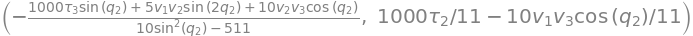

In [3]:
q1dot = v1
q2dot = v2
v1dot = -(5*(200*tau3*sym.sin(q2)+sym.sin(2*q2)*v1*v2+2*sym.cos(q2)*v2*v3)/(10*(sym.sin(q2))**2 -511))
v2dot = 10*(100*tau2 - sym.cos(q2)*v1*v3)/11
v1dot, v2dot

In [4]:
xdot = sym.Matrix([[q1dot],[v1dot],[q2dot],[v2dot]])
xdot

⎡                            v₁                            ⎤
⎢                                                          ⎥
⎢-(1000⋅τ₃⋅sin(q₂) + 5⋅v₁⋅v₂⋅sin(2⋅q₂) + 10⋅v₂⋅v₃⋅cos(q₂)) ⎥
⎢──────────────────────────────────────────────────────────⎥
⎢                          2                               ⎥
⎢                    10⋅sin (q₂) - 511                     ⎥
⎢                                                          ⎥
⎢                            v₂                            ⎥
⎢                                                          ⎥
⎢                1000⋅τ₂   10⋅v₁⋅v₃⋅cos(q₂)                ⎥
⎢                ─────── - ────────────────                ⎥
⎣                   11            11                       ⎦

In [5]:
#pick equilibrium values for our variables
v1e = 0
v2e = 0
v3e = 100 * (2 * sym.pi / 60)
q1e = sym.pi / 20
q2e = sym.pi / 4
tau2e = 0 
tau3e = 0

In [6]:
A = xdot.jacobian([q1,v1,q2,v2])
A

⎡0          1                                                                 
⎢                                                                             
⎢    -5⋅v₂⋅sin(2⋅q₂)     1000⋅τ₃⋅cos(q₂) + 10⋅v₁⋅v₂⋅cos(2⋅q₂) - 10⋅v₂⋅v₃⋅sin(q
⎢0  ─────────────────  - ─────────────────────────────────────────────────────
⎢         2                                       2                           
⎢   10⋅sin (q₂) - 511                       10⋅sin (q₂) - 511                 
⎢                                                                             
⎢                                                                             
⎢0          0                                                                 
⎢                                                                             
⎢    -10⋅v₃⋅cos(q₂)                                                           
⎢0   ───────────────                                                          
⎣           11                                      

In [7]:
B = xdot.jacobian([tau2,tau3])
B

⎡ 0            0        ⎤
⎢                       ⎥
⎢        -1000⋅sin(q₂)  ⎥
⎢ 0    ─────────────────⎥
⎢            2          ⎥
⎢      10⋅sin (q₂) - 511⎥
⎢                       ⎥
⎢ 0            0        ⎥
⎢                       ⎥
⎢1000                   ⎥
⎢────          0        ⎥
⎣ 11                    ⎦

In [8]:
A_eval = A.evalf(subs={v1:v1e,v2:v2e,v3:v3e,q1:q1e,q2:q2e,tau2:tau2e,tau3:tau3e})
A_eval

⎡0         1.0         0          0        ⎤
⎢                                          ⎥
⎢0          0          0  0.146340017725901⎥
⎢                                          ⎥
⎢0          0          0         1.0       ⎥
⎢                                          ⎥
⎣0  -6.73164081539146  0          0        ⎦

In [9]:
B_eval = B.evalf(subs={v1:v1e,v2:v2e,v3:v3e,q1:q1e,q2:q2e,tau2:tau2e,tau3:tau3e})
B_eval

⎡       0                 0        ⎤
⎢                                  ⎥
⎢       0          1.39744423159397⎥
⎢                                  ⎥
⎢       0                 0        ⎥
⎢                                  ⎥
⎣90.9090909090909         0        ⎦

In [10]:
print(f'{mechanics.mlatex(xdot)}')

\left[\begin{matrix}v_{1}\\- \frac{1000 \tau_{3} \sin{\left(q_{2} \right)} + 5 v_{1} v_{2} \sin{\left(2 q_{2} \right)} + 10 v_{2} v_{3} \cos{\left(q_{2} \right)}}{10 \sin^{2}{\left(q_{2} \right)} - 511}\\v_{2}\\\frac{1000 \tau_{2}}{11} - \frac{10 v_{1} v_{3} \cos{\left(q_{2} \right)}}{11}\end{matrix}\right]


In [11]:
A_arr = np.array(A_eval).astype(np.float64)
B_arr = np.array(B_eval).astype(np.float64)
A_arr,B_arr

(array([[ 0.        ,  1.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.14634002],
        [ 0.        ,  0.        ,  0.        ,  1.        ],
        [ 0.        , -6.73164082,  0.        ,  0.        ]]),
 array([[ 0.        ,  0.        ],
        [ 0.        ,  1.39744423],
        [ 0.        ,  0.        ],
        [90.90909091,  0.        ]]))

In [12]:
eigs = np.array([-1,-2,-3,-4])
k = signal.place_poles(A_arr, B_arr, eigs).gain_matrix
signal.place_poles(A_arr, B_arr, eigs).computed_poles

array([-4., -3., -2., -1.])

In [ ]:
# Make a controller 
class RobotController:
    def __init__(self, k, q1e,q2e,v1e,v2e,v3e,tau2e,tau3e,dt):
        self.k = k
        self.q1e = q1e
        self.q2e = q2e
        self.v1e = v1e
        self.v2e = v2e
        self.v3e = v3e
        self.tau2e = tau2e
        self.tau3e= tau3e
        self.dt = dt
    def run(self, q1, v1, q2, v2, q3):
        x = np.array([q1-q1e,v1-v1e,q2-q2e,v2-v2e])
        u = -self.k@x
        tau2 = u[0]
        tau3 = u[1]
        return tau2,tau3

controller = RobotController(k,q1e,q2e,v1e,v2e,v3e,tau2e,tau3e,dt)
robot.reset(rotor_rpm=100.)

# Choose how long we want to run the simulation, and
# compute the corresponding number of time steps
run_time = 50.
num_steps = int(run_time/robot.dt)

# Create a dictionary in which to store results
data = {
    't': np.empty(num_steps, dtype=float),
    'q1': np.empty(num_steps, dtype=float),
    'v1': np.empty(num_steps, dtype=float),
    'q2': np.empty(num_steps, dtype=float),
    'v2': np.empty(num_steps, dtype=float),
    'q3': np.empty(num_steps, dtype=float),
    'v3': np.empty(num_steps, dtype=float),
    'tau2': np.empty(num_steps, dtype=float),
    'tau3': np.empty(num_steps, dtype=float),
}

# Run the simulation loop
start_time = time.time()
for step in range(num_steps):
    # Get the current time
    t = robot.dt * step
    
    # Get the sensor measurements
    q1, v1, q2, v2, q3, v3 = robot.get_sensor_measurements()
    
    # Choose the actuator command (by running the controller)
    tau2, tau3 = controller.run(q1, v1, q2, v2, q3)
    
    # Log the data from this time step
    data['t'][step] = t
    data['q1'][step] = q1
    data['v1'][step] = v1
    data['q2'][step] = q2
    data['v2'][step] = v2
    data['q3'][step] = q3
    data['v3'][step] = v3
    data['tau2'][step] = tau2
    data['tau3'][step] = tau3
    
    # Send the actuator commands to robot and go forward one time
    # step (this is where the actual simulation happens)
    robot.set_actuator_commands(tau2, tau3)
    robot.step(t=(start_time + (robot.dt * (step + 1))))

In [ ]:
# Create a figure with three subplots, all of which share the same x-axis
fig, ax = plt.subplots(3, 1, figsize=(9, 12), sharex=True)

# Plot angle of outer gimbal on first subplot
ax[0].plot(data['t'], data['q1'], label='outer angle (rad)', linewidth=4)
ax[0].grid()
ax[0].legend(fontsize=16)
ax[0].tick_params(labelsize=14)

# Plot angular velocity of outer gimbal on second subplot
ax[1].plot(data['t'], data['v1'], label='outer angular velocity (rad / s)', linewidth=4)
ax[1].grid()
ax[1].legend(fontsize=16)
ax[1].tick_params(labelsize=14)

# Plot torques on third subplot
ax[2].plot(data['t'], data['tau2'], label='gimbal torque command (N-m)', linewidth=4)
ax[2].plot(data['t'], data['tau3'], label='rotor torque command (N-m)', linewidth=4)
ax[2].plot(data['t'], np.ones_like(data['t']) * robot.tau_max, '--', label='max joint torque', linewidth=4, color='C2')
ax[2].plot(data['t'], -np.ones_like(data['t']) * robot.tau_max, '--', linewidth=4, color='C2')
ax[2].grid()
ax[2].legend(fontsize=16)
ax[2].tick_params(labelsize=14)
ax[2].set_ylim(-1.2 * robot.tau_max, 1.2 * robot.tau_max)

# Set x-axis properties (only need to do this on the fourth
# subplot since all four subplots share the same x-axis)
ax[2].set_xlabel('time (s)', fontsize=20)
ax[2].set_xlim([data['t'][0], data['t'][-1]])

# Make the arrangement of subplots look nice
fig.tight_layout()